# Multi-Armed Bandit (k-Armed Bandit)


## References

* https://en.wikipedia.org/wiki/Multi-armed_bandit

In [1]:
from datetime import timedelta, datetime, date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Theory


* Iteratively Selects One of the multiple fixed choices
* These choices are called `arms` or `actions` or `levers`
* Property of each choice is partially known at the time of allocation but become better understood as the time passes.
    * Either we know it earlier (Partially)
    * or we'll know it with time
* these arms are `Independent`
* This algorithm works as `Best Arm Identification`
* Target here is to `Minimize Regret`
* Exploration $\leftrightarrow$ Exploitation

> Objective
>> `Minimize` the sum of rewards earned through a sequence of lever pulls.
>>
>> Each machines provides a random reward from a probability distribution specific to the machine(not known apriori)


<!-- 
## Example

* Lets say a player enters a casino to play slot machines.
* there are 10 machines, but not all machines have same reward (win %) per gamble.
* Now the player had  -->

## Actions/ Levers

In [2]:
class Levers:
    @staticmethod
    def lever_1(mu=10, sigma=5):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_2(mu=8, sigma=3):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_3(mu=5, sigma=25):
        return np.random.normal(mu, sigma)


levers = ["lever_1", "lever_2", "lever_3"]

In [3]:
def levers_cyclic_iter(levers):
    i = 0
    while True:
        if i >= len(levers):
            i = 0
        yield levers[i]
        i += 1

In [4]:
def random_choose_lever(levers):
    return np.random.choice(levers, size=None, replace=True, p=None)

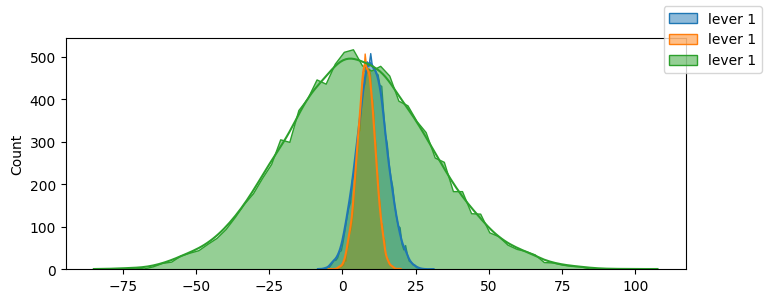

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

params = {
    "kde": True,
    "element": "poly",
    "label": "lever 1",
    "ax": ax,
}
sns.histplot([Levers.lever_1() for _ in range(10000)], **params)
sns.histplot([Levers.lever_2() for _ in range(10000)], **params)
sns.histplot([Levers.lever_3() for _ in range(10000)], **params)
fig.legend()
fig.show()

## Reward & Regret

In [6]:
def calculate_regret(total_reward, max_reward, N):
    optimum_reward = max_reward * N
    regret = optimum_reward - total_reward
    return regret

In [141]:
def get_metrics(rewardsdf: pd.DataFrame, verbose=True):
    aggdf = rewardsdf.groupby(by=["lever", "decision"], as_index=False).agg(
        ts_count=("ts", "count"),
        ts_min=("ts", "min"),
        reward_min=("reward", "min"),
        reward_mean=("reward", "mean"),
        reward_max=("reward", "max"),
        reward_sum=("reward", "sum"),
        reward_std=("reward", "std"),
    ).sort_values(by=["ts_min"])
    max_reward = aggdf["reward_mean"].max()
    total_reward = aggdf["reward_sum"].sum()
    n_iters = aggdf["ts_count"].sum()
    optimum_reward = max_reward * len(rewardsdf)

    max_reward_lever_record = aggdf[aggdf["reward_mean"] == max_reward]
    next_chosen_lever = max_reward_lever_record["lever"].iloc[0]

    regret = calculate_regret(
        total_reward=total_reward, max_reward=max_reward, N=n_iters
    )
    if verbose:
        print(
            f"""
        Iterations      : {n_iters}
        Optimum Reward  : {optimum_reward}
        Total Reward    : {total_reward} 
        Regret          : {regret}
        Rewards Agg     : 
        """
        )
        print(aggdf.to_string(justify="left", line_width=200))
    return (next_chosen_lever, aggdf, optimum_reward, total_reward, regret)

In [142]:
def plot_reward(rewarddf, x="ts"):
    rewarddf["decision-lever"] = rewarddf["decision"] + "-" + rewarddf["lever"]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    line_plot_params = {
        "alpha": 0.6,
        "color": "grey",
        "linewidth": 0.5,
    }

    sns.lineplot(data=rewarddf, x=x, y="reward", ax=ax[0], **line_plot_params)
    sns.scatterplot(data=rewarddf, x=x, y="reward", hue="decision-lever", ax=ax[0])

    sns.lineplot(data=rewarddf, x=x, y="reward_cumsum", ax=ax[1], **line_plot_params)
    sns.scatterplot(
        data=rewarddf, x=x, y="reward_cumsum", hue="decision-lever", ax=ax[1]
    )

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    return fig

## Exploration & Exploitation

In [143]:
class Model:
    def __init__(self, levers) -> None:
        self.ts_idx = datetime(2024, 1, 1, 0, 0, 0)
        self.timedelta = timedelta(minutes=30)
        self.seq_idx = 0
        self.decision_idx = 0
        self.rewards = {}
        self.levers = levers
        self.chosen_lever = None

    def get_decision_idx(self, decision):
        if (
            len(self.rewards) == 0
            or self.rewards[len(self.rewards)][-1]["decision"] != decision
        ):
            self.decision_idx += 1
        return self.decision_idx

    def get_lever(self):
        if self.chosen_lever is None:
            if len(self.rewards) == 0:
                raise ValueError("First run explore to get some data")

            last_iter_rewardsdf = pd.DataFrame(self.rewards[len(self.rewards)])
            self.chosen_lever = get_metrics(last_iter_rewardsdf, verbose=False)[0]
        return self.chosen_lever

    def update_rewards(self, reward_payload, decision_idx):
        if decision_idx not in self.rewards.keys():
            self.rewards[decision_idx] = []
        self.rewards[decision_idx].append(reward_payload)

    def explore(self, enforce_lever=None):
        self.chosen_lever = None
        explore_lever = enforce_lever or random_choose_lever(self.levers)
        reward = getattr(Levers, explore_lever)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "explore"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            reward_payload={
                "decision_idx": decision_idx,
                "decision": decision,
                "seq": self.seq_idx,
                "ts": self.ts_idx,
                "lever": explore_lever,
                "reward": reward,
            },
            decision_idx=decision_idx,
        )

    def exploit(self):
        chosen_lever = self.get_lever()
        reward = getattr(Levers, chosen_lever)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "exploit"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            reward_payload={
                "decision_idx": decision_idx,
                "decision": decision,
                "seq": self.seq_idx,
                "ts": self.ts_idx,
                "lever": chosen_lever,
                "reward": reward,
            },
            decision_idx=decision_idx,
        )

    @property
    def combine_rewards(self):
        combine_rewards = []
        for key in self.rewards:
            combine_rewards.extend(self.rewards[key])
        combine_rewards
        return combine_rewards

    @property
    def rewardsdf(self):
        df = pd.DataFrame(self.combine_rewards)
        df.insert(len(df.columns), column="reward_cumsum", value=df["reward"].cumsum())
        return df

## Only Exploration


### Stochastic


        Iterations      : 300
        Optimum Reward  : 3232.8481495925807
        Total Reward    : 2540.3512558524126 
        Regret          : 692.4968937401682
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum   reward_std
1  lever_2  explore  103      2024-01-01 00:30:00   1.850477    7.960347    16.131128    819.915703   2.808770 
2  lever_3  explore  101      2024-01-01 01:00:00 -53.366730    6.791328    56.365019    685.924145  24.662436 
0  lever_1  explore   96      2024-01-01 01:30:00  -2.625043   10.776160    21.034932   1034.511408   4.843306 


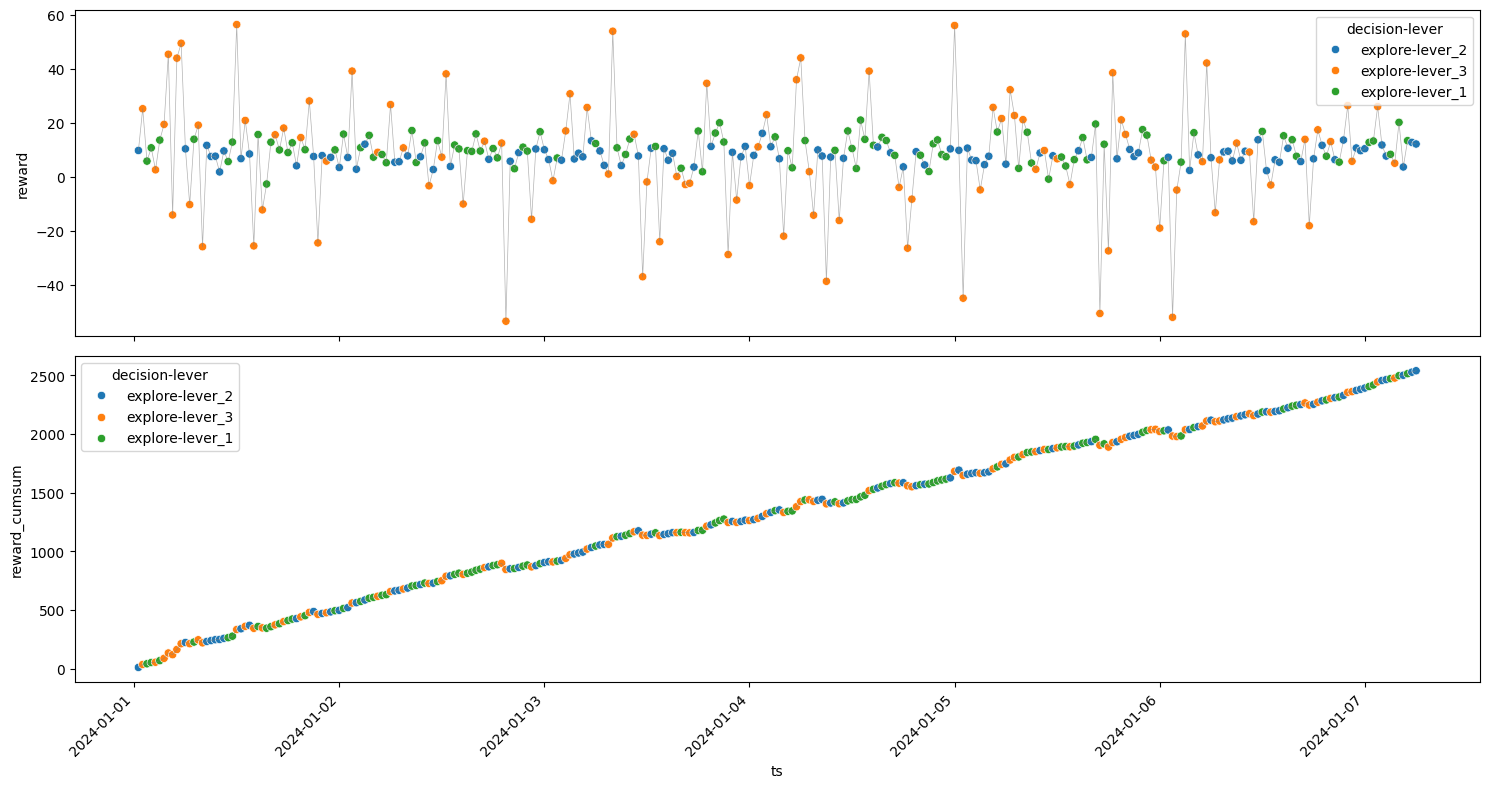

In [144]:
model = Model(levers)

for _ in range(300):
    model.explore()

explore_rewarddf = model.rewardsdf
get_metrics(explore_rewarddf);
plot_reward(explore_rewarddf);

### Sequential


        Iterations      : 300
        Optimum Reward  : 2942.2529734541445
        Total Reward    : 2223.787592659979 
        Regret          : 718.4653807941654
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum  reward_std
0  lever_1  explore  100      2024-01-01 00:30:00  -3.828787   9.807510     24.299339   980.750991   5.181648 
1  lever_2  explore  100      2024-01-01 01:00:00  -2.070852   7.987573     13.634422   798.757265   2.837325 
2  lever_3  explore  100      2024-01-01 01:30:00 -54.829071   4.442793     72.502116   444.279336  24.422692 


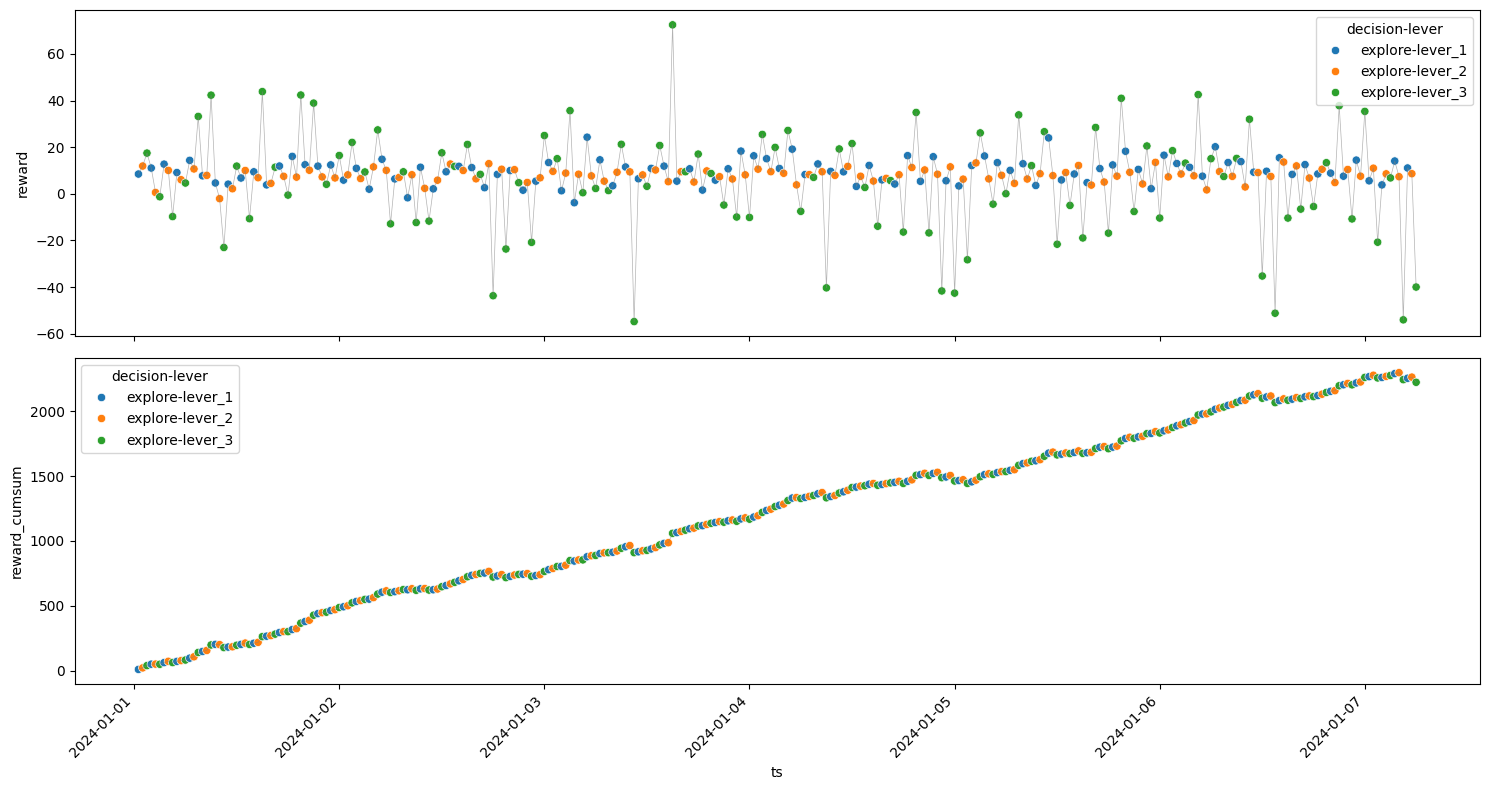

In [145]:
levers_iterator = levers_cyclic_iter(levers)
model = Model(levers)

for _ in range(300):
    model.explore(next(levers_iterator))

explore_rewarddf = model.rewardsdf
get_metrics(explore_rewarddf);
plot_reward(explore_rewarddf);

## Only Exploitation



        Iterations      : 300
        Optimum Reward  : 4516.342104180537
        Total Reward    : 2404.174332646131 
        Regret          : 2112.167771534406
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum   reward_std
0  lever_1  explore    1      2024-01-01 00:30:00   7.913010    7.913010     7.913010      7.913010       NaN  
2  lever_2  explore    1      2024-01-01 01:00:00  15.054474   15.054474    15.054474     15.054474       NaN  
3  lever_3  explore    1      2024-01-01 01:30:00  -9.993714   -9.993714    -9.993714     -9.993714       NaN  
1  lever_2  exploit  297      2024-01-01 02:00:00   0.602954    8.051180    16.165745   2391.200563  2.751035  


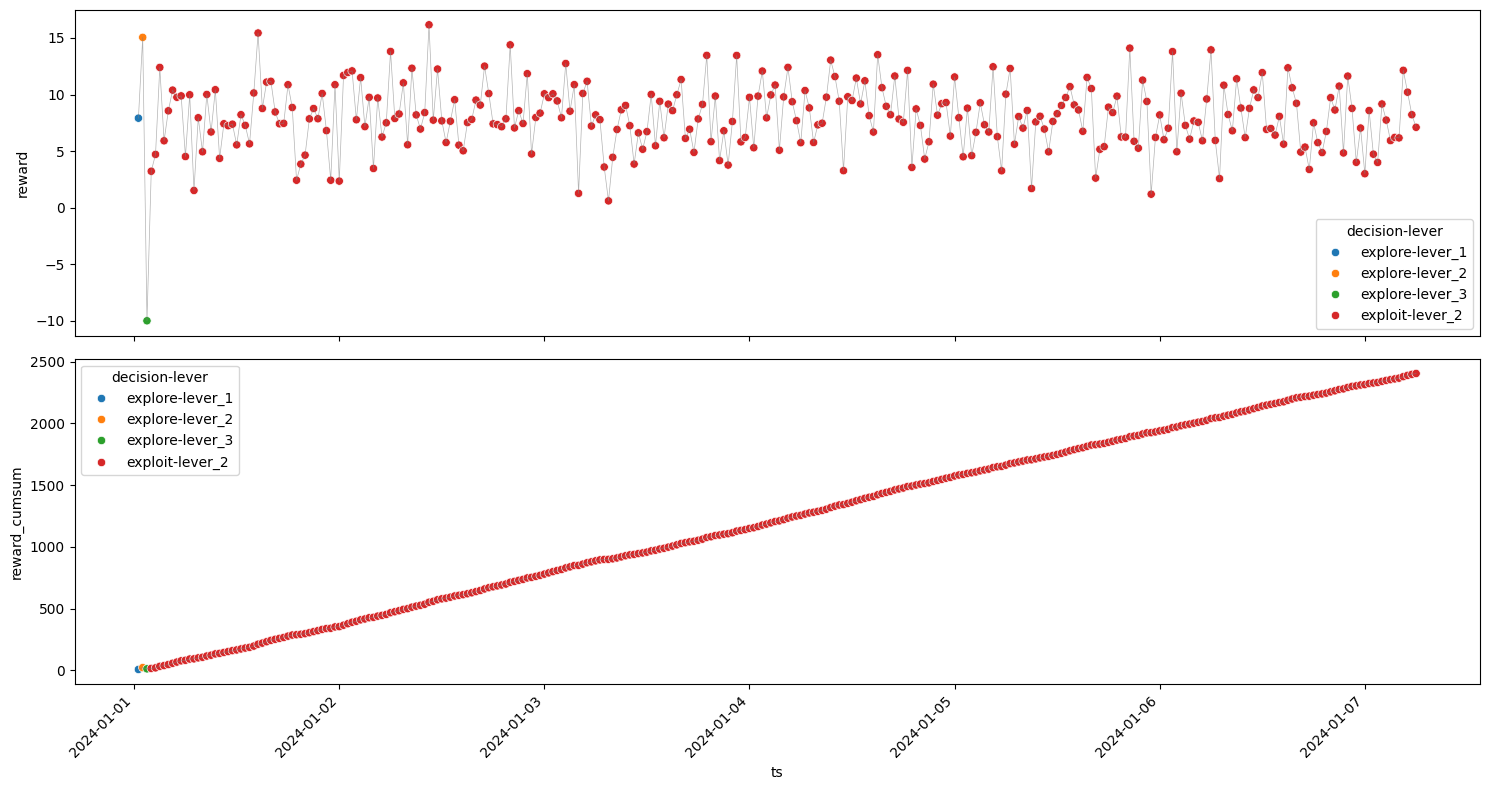

In [146]:
levers_iterator = levers_cyclic_iter(levers)

model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

for i in range(297):
    model.exploit()

exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);


        Iterations      : 300
        Optimum Reward  : 3961.0751963871994
        Total Reward    : 3123.6873996566396 
        Regret          : 837.3877967305598
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum   reward_std
1  lever_1  explore    1      2024-01-01 00:30:00  13.203584   13.203584    13.203584     13.203584       NaN  
2  lever_2  explore    1      2024-01-01 01:00:00   9.777159    9.777159     9.777159      9.777159       NaN  
3  lever_3  explore    1      2024-01-01 01:30:00  -5.828939   -5.828939    -5.828939     -5.828939       NaN  
0  lever_1  exploit  297      2024-01-01 02:00:00  -5.313423   10.459716    22.936828   3106.535596  5.072439  


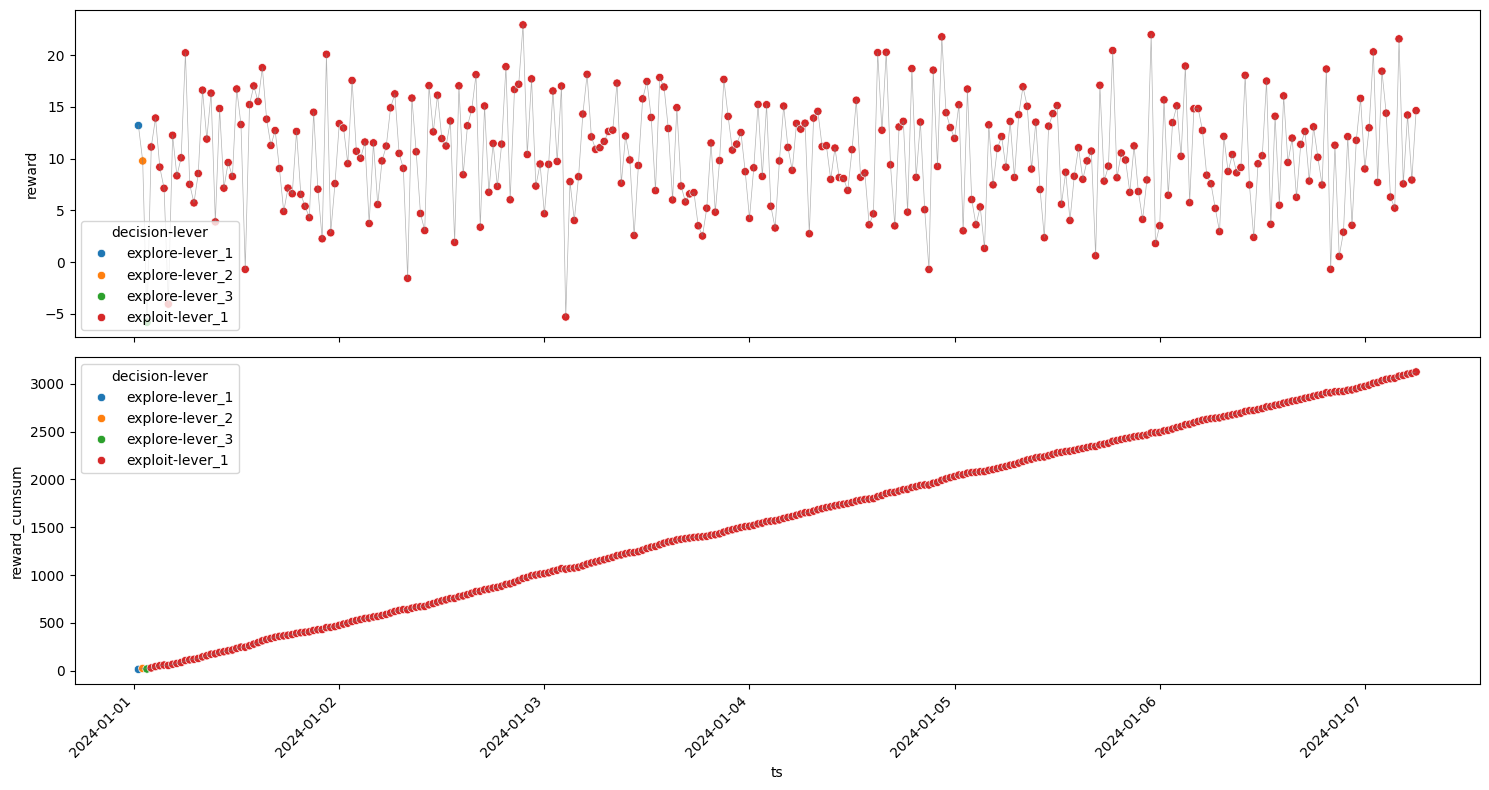

In [147]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

model.chosen_lever = "lever_1"

for i in range(297):
    model.exploit()

exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);


        Iterations      : 300
        Optimum Reward  : 5291.028365291018
        Total Reward    : 2384.637096859665 
        Regret          : 2906.3912684313536
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum   reward_std
0  lever_1  explore    1      2024-01-01 00:30:00   4.517456    4.517456     4.517456      4.517456       NaN  
2  lever_2  explore    1      2024-01-01 01:00:00   8.561059    8.561059     8.561059      8.561059       NaN  
3  lever_3  explore    1      2024-01-01 01:30:00  17.636761   17.636761    17.636761     17.636761       NaN  
1  lever_2  exploit  297      2024-01-01 02:00:00  -1.374969    7.925663    15.269515   2353.921821  2.866858  


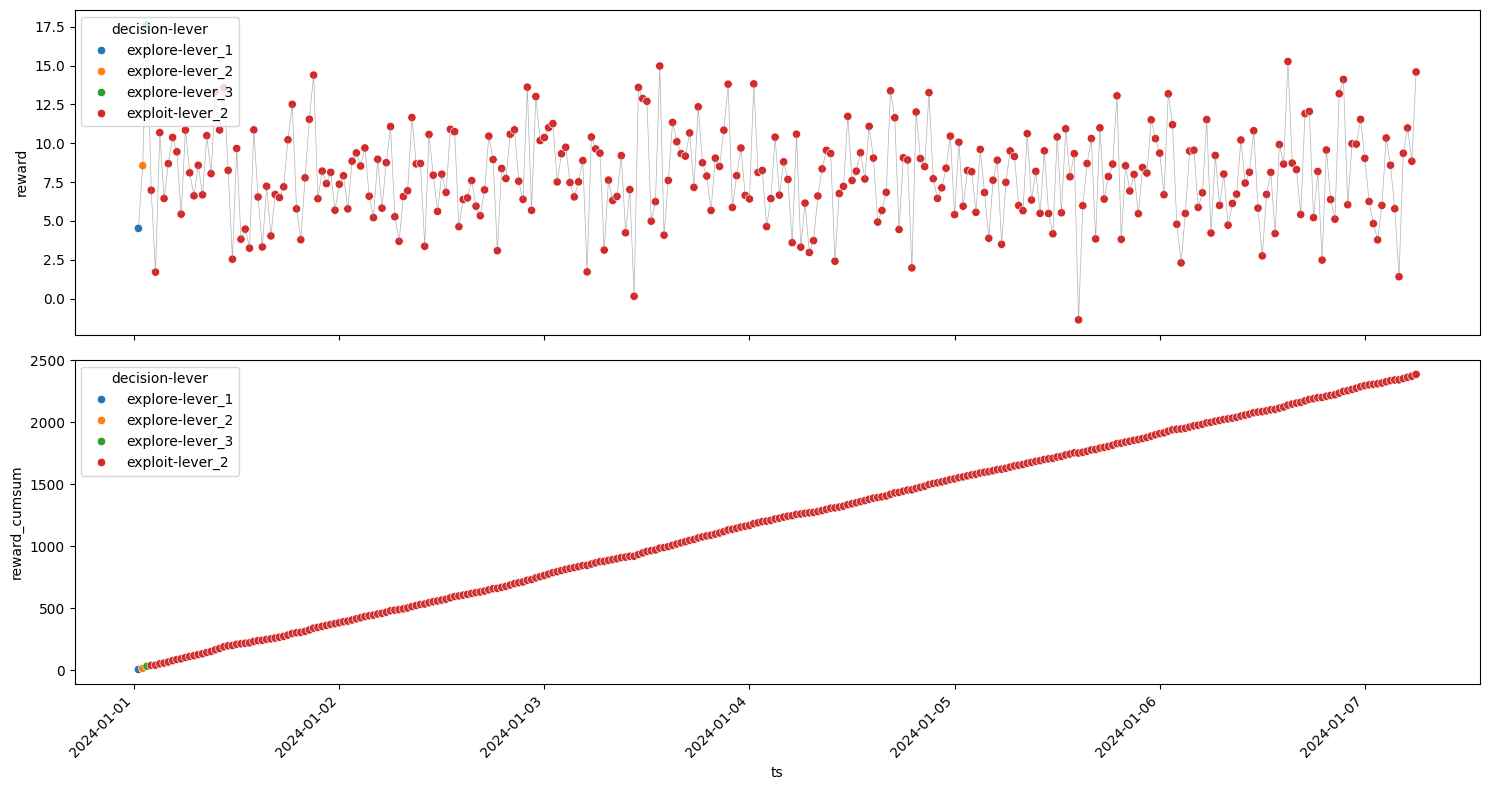

In [148]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

model.chosen_lever = "lever_2"

for i in range(297):
    model.exploit()

exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);


        Iterations      : 300
        Optimum Reward  : 3397.9214544437473
        Total Reward    : 957.776390087072 
        Regret          : 2440.1450643566754
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum  reward_std
0  lever_1  explore    1      2024-01-01 00:30:00  -0.881226   -0.881226    -0.881226    -0.881226        NaN 
1  lever_2  explore    1      2024-01-01 01:00:00  11.326405   11.326405    11.326405    11.326405        NaN 
3  lever_3  explore    1      2024-01-01 01:30:00 -29.587897  -29.587897   -29.587897   -29.587897        NaN 
2  lever_3  exploit  297      2024-01-01 02:00:00 -64.502685    3.289290    83.337247   976.919108  26.725349 


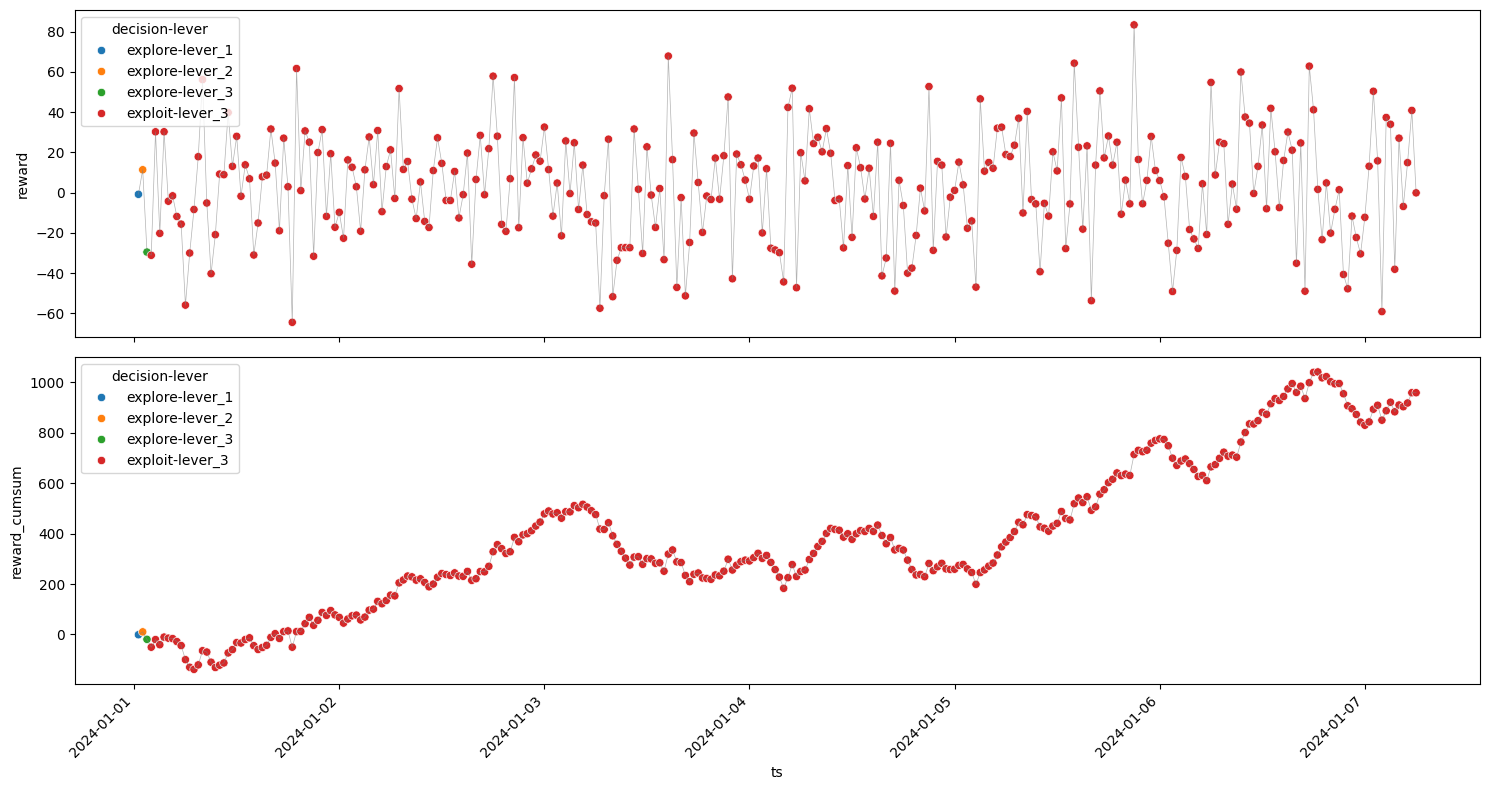

In [149]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

model.chosen_lever = "lever_3"

for i in range(297):
    model.exploit()

exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);


## Alternative Sequentially Exploration & Exploitation


In [150]:
def explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=levers,
):

    model = Model(levers)
    run_explore = True

    explore_counter, exploit_counter = 0, 0

    for i in range(n_iterations):
        if run_explore:
            model.explore()
            explore_counter += 1
        else:
            model.exploit()
            exploit_counter += 1

        if explore_counter == explore_iters:
            run_explore = False
            explore_counter = 0

        if exploit_counter == exploit_iters:
            run_explore = True
            exploit_counter = 0

    return model


        Iterations      : 300
        Optimum Reward  : 3343.1475396222004
        Total Reward    : 2324.9045901217387 
        Regret          : 1018.2429495004617
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum   reward_std
3  lever_2  explore   46      2024-01-01 00:30:00   1.113342    7.783553    14.120998    358.043454   2.965602 
1  lever_1  explore   48      2024-01-01 02:00:00  -0.418421   11.143825    20.339561    534.903606   4.837612 
5  lever_3  explore   56      2024-01-01 05:00:00 -61.274752   -1.205295    85.790498    -67.496543  29.260469 
0  lever_1  exploit  120      2024-01-01 05:30:00  -1.633084   10.522030    22.065830   1262.643614   4.600321 
4  lever_3  exploit   20      2024-01-01 15:30:00 -41.827965    7.827119    45.922014    156.542372  26.645643 
2  lever_2  exploit   10      2024-01-03 17:30:00   2.376800    8.026809    15.382424     80.268087   4.180970 


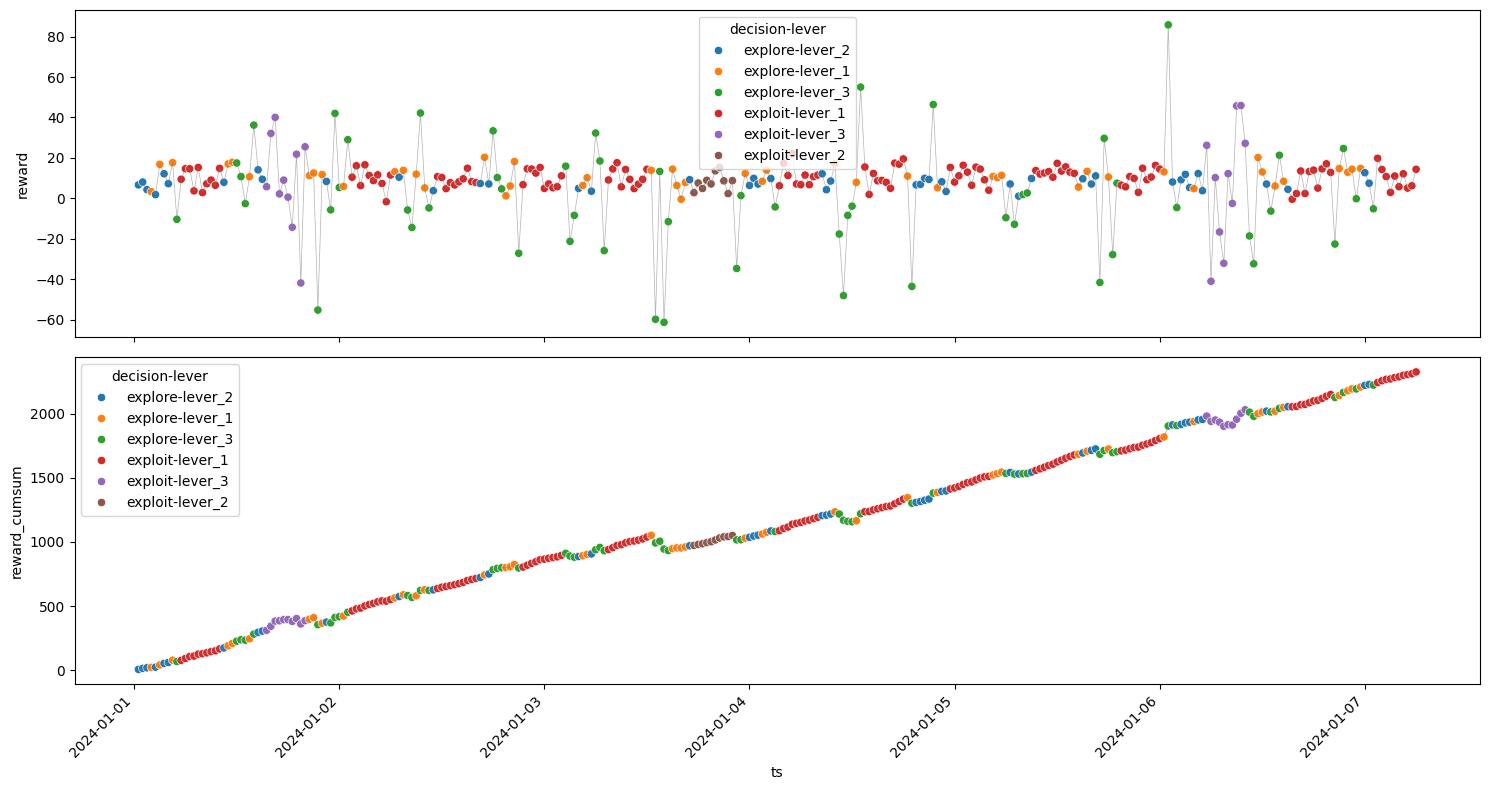

In [151]:
model = explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
)
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);


        Iterations      : 300
        Optimum Reward  : 2996.738881011077
        Total Reward    : 2450.619163715062 
        Regret          : 546.1197172960151
        Rewards Agg     : 
        
  lever    decision  ts_count ts_min               reward_min  reward_mean  reward_max  reward_sum  reward_std
3  lever_2  explore   29      2024-01-01 00:30:00   0.897534   7.828620     14.763511   227.029975   2.992453 
1  lever_1  explore   34      2024-01-01 01:00:00  -2.079021   9.989130     25.087087   339.630407   6.615407 
5  lever_3  explore   37      2024-01-01 02:30:00 -54.198895   5.250682     62.676278   194.275246  25.470076 
0  lever_1  exploit  100      2024-01-01 03:00:00   0.156916   9.347744     21.378507   934.774421   4.402150 
4  lever_3  exploit   50      2024-01-01 18:00:00 -71.763051   7.220775     84.868345   361.038763  31.141608 
2  lever_2  exploit   50      2024-01-02 01:30:00   1.619409   7.877407     12.615051   393.870352   2.360782 


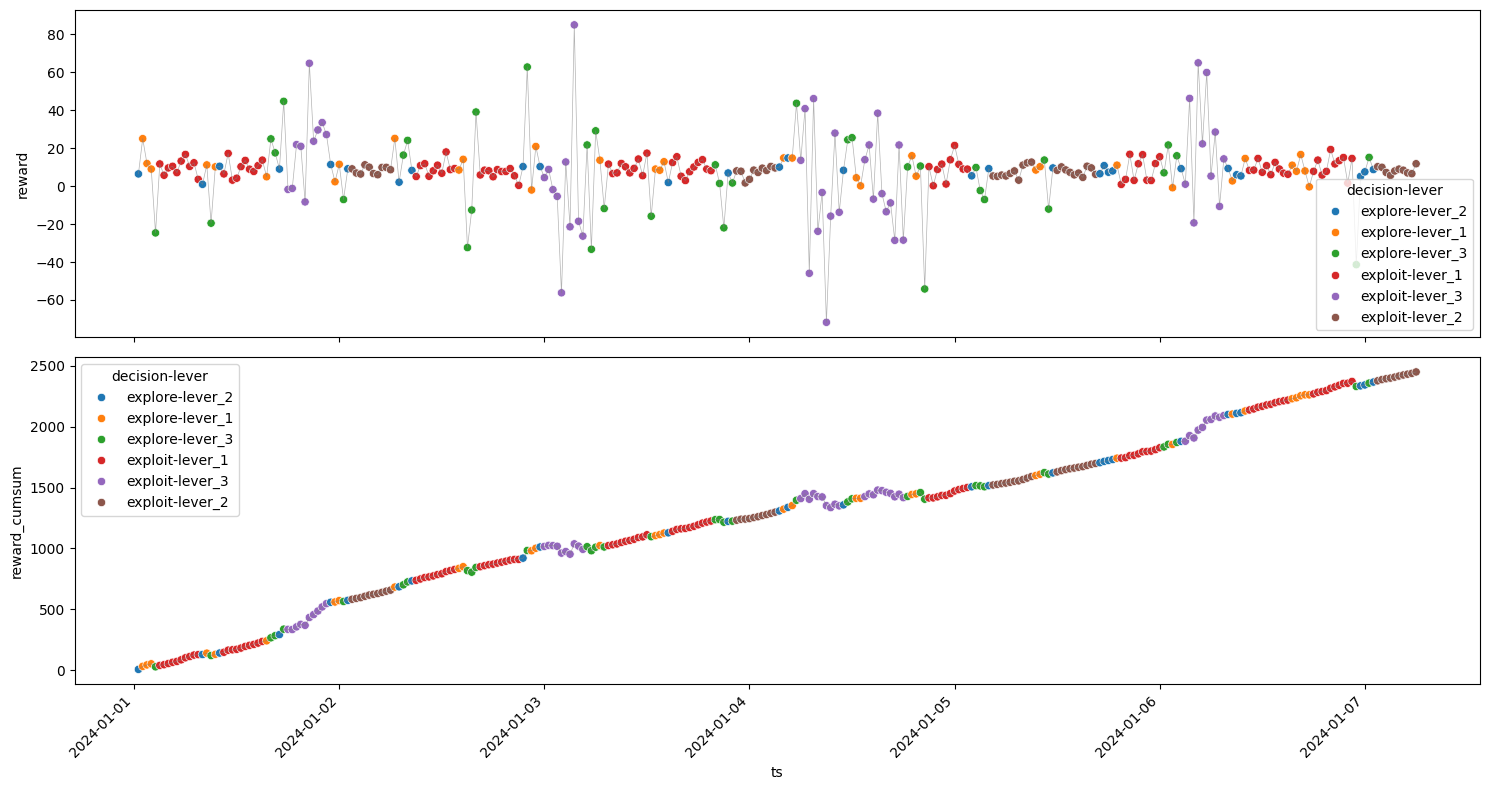

In [152]:
model = explore_exploit(
    n_iterations=300,
    explore_iters=5,
    exploit_iters=10,
    levers=levers,
)
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);